## Test om videoherkenning te realiseren

#### Waternet Datalab, Rob van Putten, versie 2017-01

### Uitleg script
In dit notebook gaan we proberen om een eerste aanzet te maken van het herkennen van dieren en mensen vanuit drone camera footage.

Het idee is om eerst via KMeans een clustering van kleuren (of zwart-wit) te realiseren waarna deze uitvoer weer gebruikt kan worden in de volgende stap.

We beginnen met het importeren van de bibliotheken;

In [1]:
import numpy as np
from scipy import misc
from sklearn.utils import shuffle
from sklearn.metrics import pairwise_distances_argmin
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

from time import time
import copy

%matplotlib inline

We gaan het algoritme trainen op de volgende zwart wit afbeelding waarbij links onder het midden duidelijk dieren te herkennen zijn in de vorm van een zwarte pixelbrei.

![title](data/image02.png)



Het idee is om een model te trainen dat de kleurdiepte beperkt tot een niveau waarbij de dieren / mensen nog apart waarneembaar zijn. Dit is een unsupervised model dus er hangen nog geen labels aan.

We lezen het bestand en de afbeeldingen in;

In [2]:
im = misc.imread('image02.png')
w, h, d = im.shape

We beperken de selectie tot 32 grijstinten (niet te verwarren met de erotische boekenreeks..)

In [5]:
n_colors = 32

We zetten de kleurdata (0-255) om in waardes tussen de 0. en de 1.

In [6]:
data = np.array(im, dtype=np.float64) / 255

En we maken er een 2D matrix van

In [7]:
X = np.reshape(data, (w * h, d))

We trainen het model op de hele afbeelding. Dat is best inefficient maar zolang het binnen de minuut gebeurt is er nog geen man overboord.

In [8]:
t0 = time()
kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(X)
print("done in %0.3fs." % (time() - t0))

done in 39.808s.


Nu kunnen we dus een predicitie maken van alle punten en in welk kleuren cluster ze vallen. We kunnen dit doen voor elke willekeurige afbeelding.

**NB** dit werkt natuurlijk wel alleen als de kleuren van de afbeelding constant zijn, niet dat er ineens (zoals in de video) naar rood / groen etc geschakeld wordt.

**NB** een preprocess stap zou kleur -> z/w zijn, beter voor de processing time, nagaan of dat mogelijk is of dat dat de classificatie bemoeilijkt.

In [10]:
t0 = time()
labels = kmeans.predict(X)
print("done in %0.3fs." % (time() - t0))

done in 0.488s.


Dat is mooi... binnen de seconde een predictie en dat met 1 CPU kern.. zo zou je dus rond de 1 a 2 frames per seconde kunnen taggen, dat lijkt me voldoende snel.

**NB** een mogelijke optimalisatie is het terugbrengen van het aantal te clusteren kleuren. Dat moet uitgeprobeerd worden.

We schrijven nu een functie die in staat is om de afbeelding opnieuw op te bouwen maar dan met de geclusterde n_colors kleuren.

In [11]:
def recreate_image(codebook, labels, w, h):
    """Recreate the (compressed) image from the code book & labels"""
    d = codebook.shape[1]
    image = np.zeros((w, h, d))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = codebook[labels[label_idx]]
            label_idx += 1
    return image

We slaan de kleuren op die bij de labels horen

In [14]:
codebook_random = shuffle(X, random_state=0)[:n_colors + 1]

We bepalen per pixel welke van de n_colors kleuren het dichtste bij de originele pixelkleur ligt

In [ ]:
labels_random = pairwise_distances_argmin(codebook_random, X, axis=0)

Voor de goede orde tonen we nogmaals het origineel

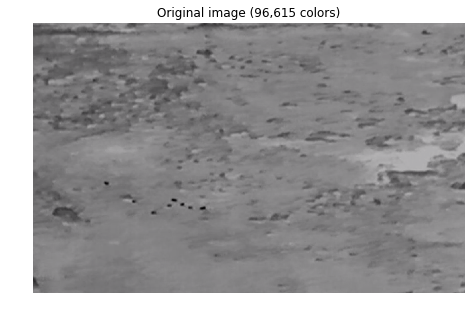

In [17]:
plt.figure(1)
plt.clf()
ax = plt.axes([0, 0, 1, 1])
plt.axis('off')
plt.title('Original image (96,615 colors)')
_ = plt.imshow(im)

En nu het belangrijkste.. we gaan per clusterkleur kijken wat er geidentificeerd is. De hoop is dat we ergens een cluster ontdekt hebben dat de zwarte objecten linksonder in de foto herkent. Dan is er dus een cluster dat in staat is om ons te vertellen waar de dieren zijn.

Dit proces duurt wel lang maar is enkel voor onderzoeksdoeleinden.

/home/breinbaas/.virtualenvs/cv/local/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


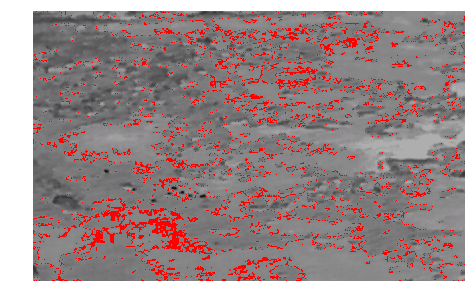

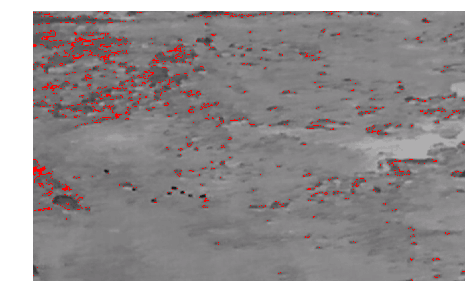

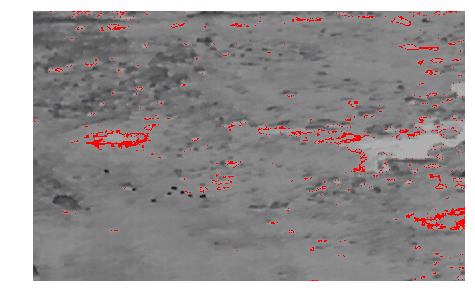

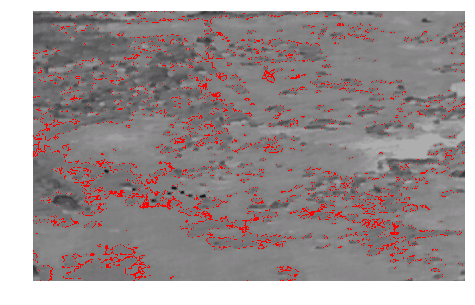

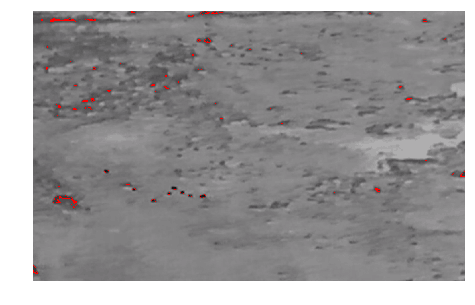

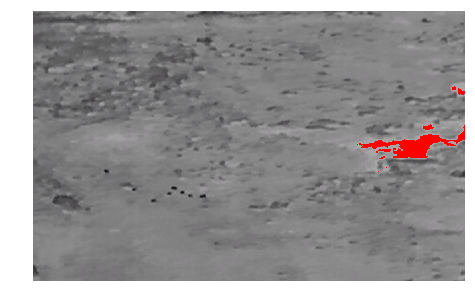

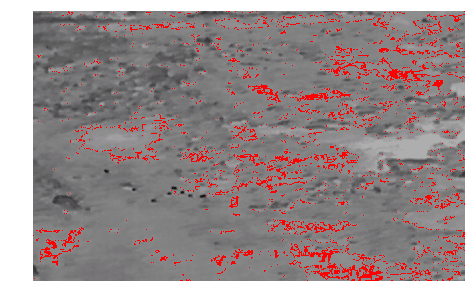

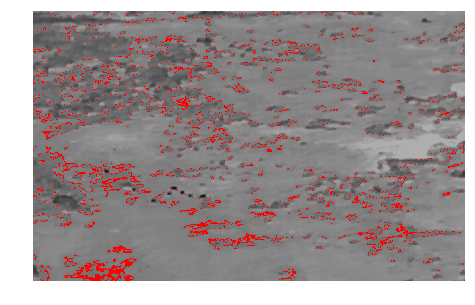

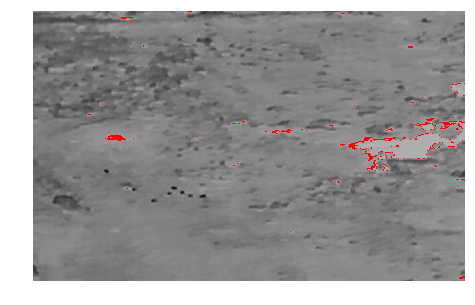

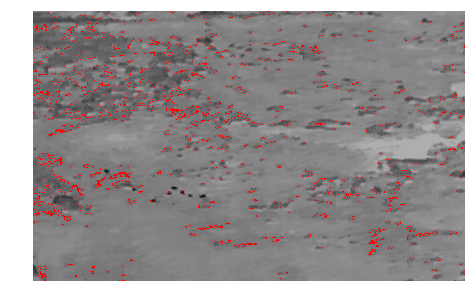

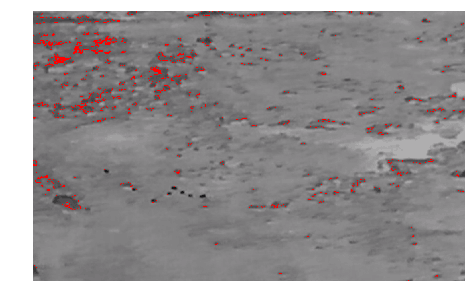

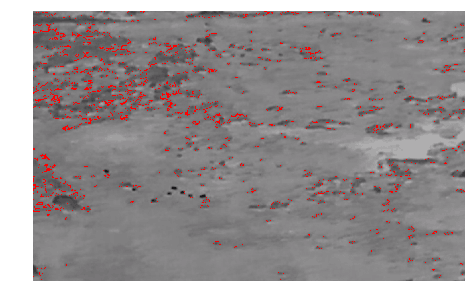

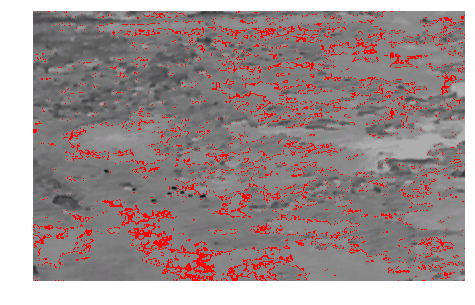

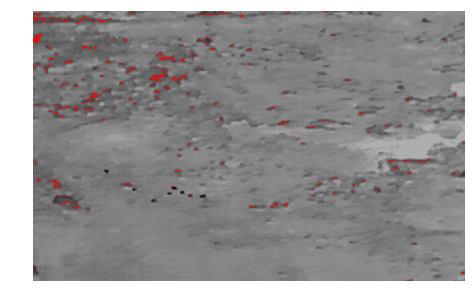

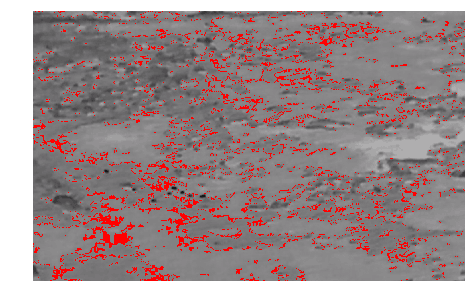

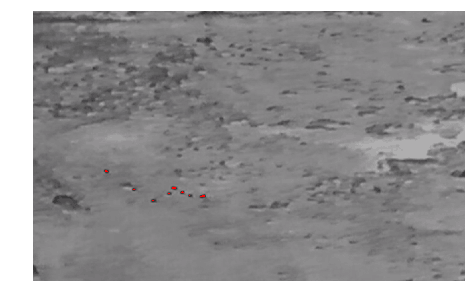

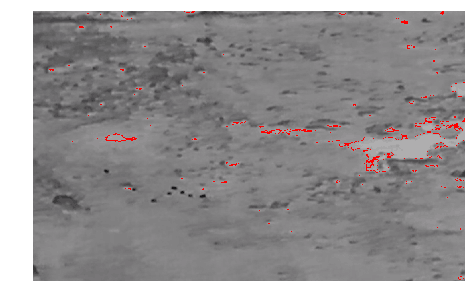

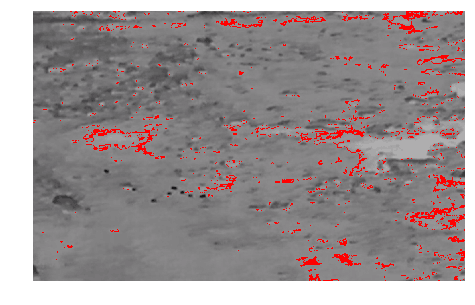

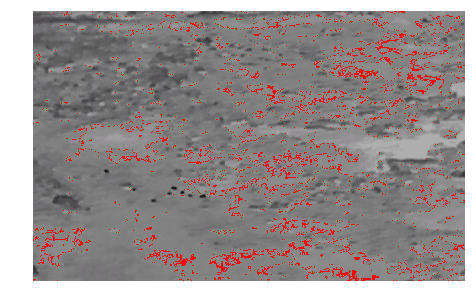

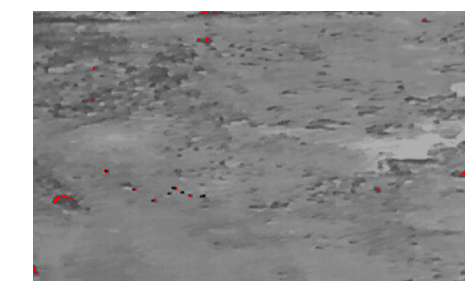

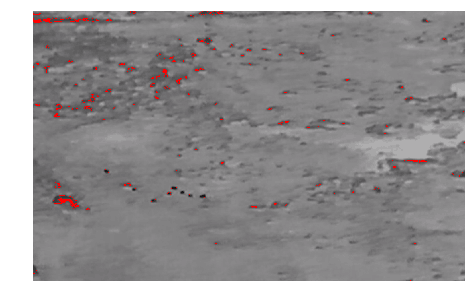

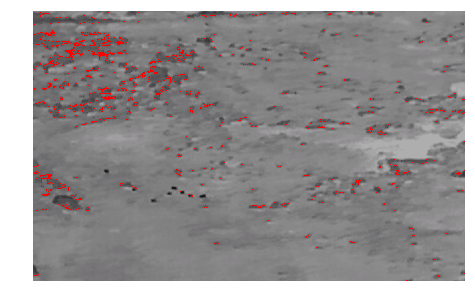

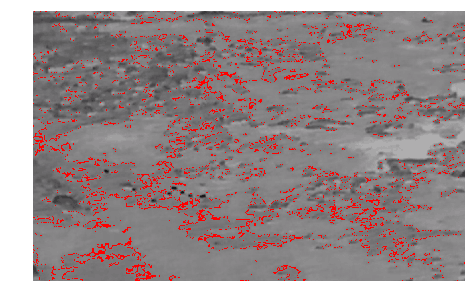

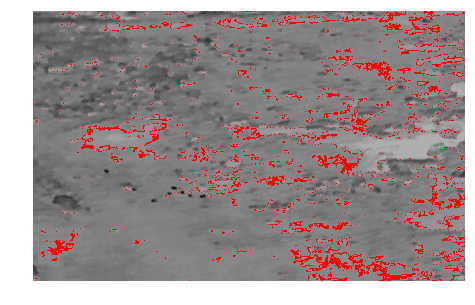

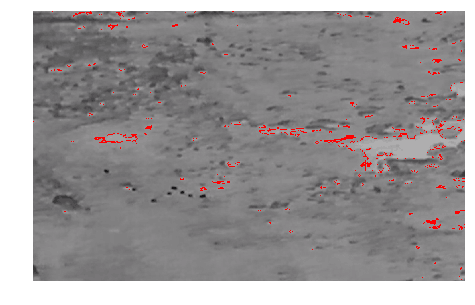

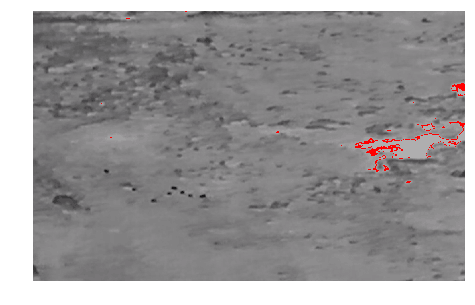

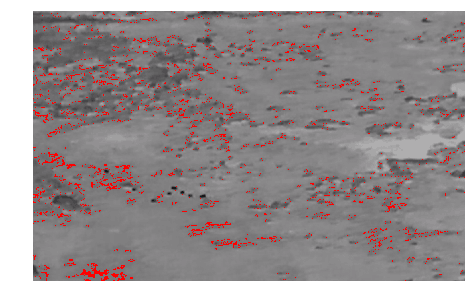

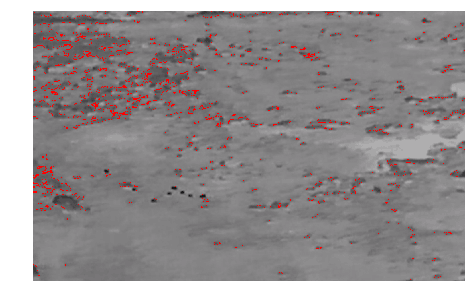

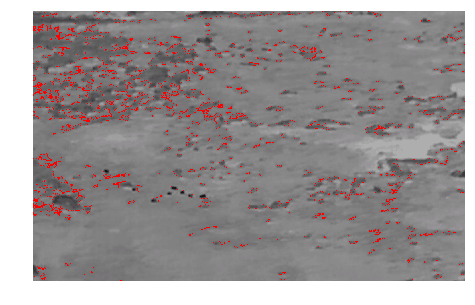

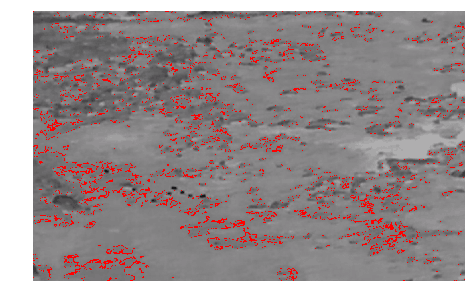

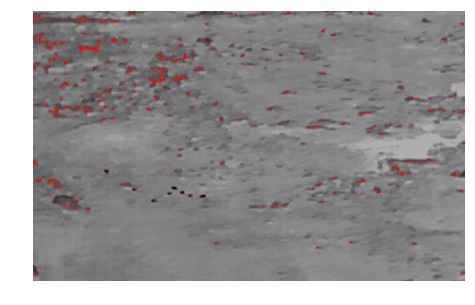

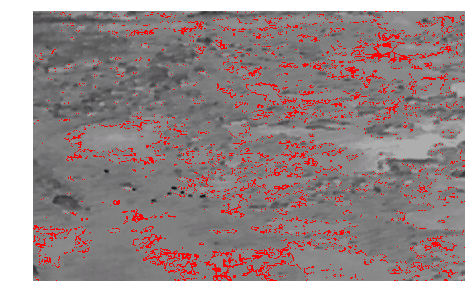

In [18]:
for i in range(n_colors):
    plt.figure(i+1)
    plt.clf()
    ax = plt.axes([0, 0, 1, 1])
    plt.axis('off')
    codebook = copy.deepcopy(kmeans.cluster_centers_)
    codebook[i] = np.array([1.0, 0.0, 0.0])
    
    #plt.title('Quantized image (64 colors, K-Means)')
    plt.imshow(recreate_image(codebook, labels, w, h))

Hoera, als je goed zoekt zie je dat er een filter is dat precies alle dieren uitfiltert!

Ik heb het filter plaatje hieronder toegevoegd;

![title](data/filter.png)

Nu nadenken over mogelijke vervolgstappen want hoe gaan we automatisch bepalen dat dit het juiste filter is dat we voortaan toe moeten passen.

Daarnaast kun je je ook voorstellen dat je dit gewoon doet door softwarematig naar een bepaalde kleur te zoeken. Daar heb je geen ML voor nodig maar wat is sneller en vooral hoe gaan we nu verder om de individuele objecten te herkennen.

Wordt vervolgd...